In [23]:
from k_means_constrained import KMeansConstrained
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import rpy2
import rpy2.robjects as ro
import os
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
import time
import random
import time
from numpy.random import seed
from scipy.stats import f

In [24]:
random.seed(time.time())
seed(int(time.time()))

In [25]:
df = pd.read_csv("https://raw.githubusercontent.com/thistleknot/Python-Stock/master/data/raw/states.csv")

x_std = StandardScaler().fit_transform(df.iloc[:,1:])

pca = PCA(svd_solver='full')
pca.fit(x_std)
pca.explained_variance_
print(pca.explained_variance_ratio_.cumsum())

#pca = PCA(n_components=1)
#pca.fit(X)
X_pca = pd.DataFrame(pca.transform(x_std))

[0.4300452  0.64027541 0.75615596 0.82679405 0.88494424 0.92799797
 0.96156524 0.98000444 0.99484731 1.        ]


In [26]:
def findknee(xdata):
    rate_of_change=(xdata[0]-xdata[-1])/(len(xdata)-1)
    #print(rate_of_change)
    delta = xdata-xdata[-1]
    deltas = []
    deltas.append(delta[0])
    for d in range(1,len(xdata)):
        deltas.append(deltas[d-1]-rate_of_change)
    #print(deltas)
    for d in range(0,len(xdata)):
        deltas[d]=delta[d]-deltas[d]
    return(np.round(np.abs(deltas)))


In [27]:
init_min = 2
init_max = 5

In [28]:
def deriveANOVA(clf, df):

    labels = clf.labels_
    clusters = clf.n_clusters
    centers = clf.cluster_centers_
        
    within_ss = []

    for n in range(0,clusters):
      #WSS means the sum of distances between the points and the corresponding centroids for each cluster
      data = df[labels==(n)]
      within_ss.append(((data - centers[n])**2).sum(1).sum())

    WSS = total_within_ss = np.sum(within_ss)

    print('wss',total_within_ss)

    #sum of ((deviation from variable means) squared)
    tot_ss = np.sum(np.sum((df-df.mean())**2))
    print('tot_ss',tot_ss)

    cluster_BSS = []
    for n in range(0,clusters):
      #sum((variable/column means cluster - variable/column means data)^2)*len(cluster members)
      BSS = np.sum((df[labels==(n)].mean()-np.array(np.mean(df)))**2)*len(df[labels==(n)])
      cluster_BSS.append(BSS)

    BSS = np.sum(cluster_BSS)
    print('bss',BSS)
    
    return(tot_ss, BSS, within_ss)

def findOptimalK_ANOVA(df, mink=2, maxk=6, init_min=2, init_max=5):

    tss = []
    bss = []
    wss = []

    for k in range(mink,maxk):
        print(k)

        print(max(init_min,k+1))
        clf = KMeansConstrained(n_clusters=k, size_min=max(init_min,k+1), size_max=max(np.ceil(len(df)/k),init_max), init='k-means++', n_init=100, max_iter=100, tol=0.0001, verbose=False, random_state=int(time.time()), copy_x=True, n_jobs=4)
        clf.fit_predict(np.array(df))

        tot_ss, BSS, within_ss = deriveANOVA(clf, df)
       
        wss.append(within_ss)
        tss.append(tot_ss)
        bss.append(BSS)

    return(tss, bss, wss)
    

In [29]:
mink = 2
maxk = 6
tss, bss, wss = findOptimalK_ANOVA(X_pca, mink = mink, maxk = maxk)

2
3
wss 357.9603560916379
tot_ss 500.00000000000006
bss 142.03964390836228
3
4
wss 295.3354131730565
tot_ss 500.00000000000006
bss 204.6645868269436
4
5
wss 245.29889619365105
tot_ss 500.00000000000006
bss 254.7011038063491
5
6
wss 232.12738170977858
tot_ss 500.00000000000006
bss 267.8726182902215


4


C:\Users\User\AppData\Local\Temp/ipykernel_1312/5969989.py:7: RuntimeWarning: invalid value encountered in true_divide
  temp_df = pd.DataFrame(bss_/wss_).replace([np.inf, -np.inf, np.NaN], 0)


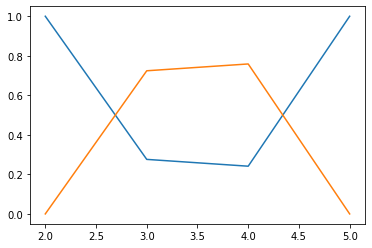

In [30]:
bss_ = findknee(bss)
bss_ = bss_/np.max(bss_)

wss_ = findknee(np.array(pd.DataFrame(wss).mean(1)))
wss_ = wss_/np.max(wss_)

temp_df = pd.DataFrame(bss_/wss_).replace([np.inf, -np.inf, np.NaN], 0)
temp_df.index = np.array(range(0,len(wss_)))+mink
#plt.plot(temp_df)

set_ = np.abs(temp_df-1)
plt.plot(set_)

optimal_k = np.argmin(set_)+mink
plt.plot(abs(set_-1))
 
print(optimal_k)

In [31]:
bss

[142.03964390836228, 204.6645868269436, 254.7011038063491, 267.8726182902215]

In [32]:
clf = KMeansConstrained(n_clusters=optimal_k, size_min=init_min, size_max=max(np.ceil(len(df)/optimal_k),init_max), init='k-means++', n_init=100, max_iter=100, tol=0.0001, verbose=False, random_state=None, copy_x=True, n_jobs=4)
clf.fit_predict(X_pca)


array([1, 3, 0, 1, 3, 2, 2, 3, 3, 3, 2, 0, 3, 3, 0, 0, 1, 1, 0, 2, 2, 3,
       2, 1, 3, 0, 0, 3, 2, 2, 1, 2, 1, 0, 3, 1, 0, 3, 2, 1, 0, 1, 3, 0,
       2, 2, 2, 1, 0, 0])

In [34]:
labels = clf.labels_
clusters = clf.n_clusters
centers = clf.cluster_centers_

print(labels)

tot_ss, BSS, within_ss = deriveANOVA(clf, X_pca)


[1 3 0 1 3 2 2 3 3 3 2 0 3 3 0 0 1 1 0 2 2 3 2 1 3 0 0 3 2 2 1 2 1 0 3 1 0
 3 2 1 0 1 3 0 2 2 2 1 0 0]
wss 245.298896193651
tot_ss 500.00000000000006
bss 254.70110380634912


In [35]:
Global_F = (BSS/(optimal_k-1))/(np.mean(within_ss)/(len(X_pca)-optimal_k))
global_sig = 1-f.cdf(Global_F, (len(X_pca)-optimal_k), len(X_pca)-1)

ind_F_scores = []

for w in range(0,len(within_ss)):

    dfn = (optimal_k-1)
    dfd = np.sum(labels==w)-optimal_k

    F_score = (BSS/dfn)/(within_ss[w]/(dfd))
    ind_F_scores.append(F_score)

print("Global F:",Global_F)
print("Global Sig:",global_sig)
print("F-Scores:", ind_F_scores)

print("P-Scores:", 1-f.cdf(ind_F_scores, dfn, dfd))

Global F: 63.68421522692151
Global Sig: 1.1102230246251565e-16
F-Scores: [19.608617446046736, 11.527707169050906, 9.180798432858804, 10.679519039346697]
P-Scores: [0.00027581 0.00194839 0.00421992 0.00253791]


In [36]:
df['cluster'] = labels

In [37]:
wd = os.getcwd()

if (os.defpath==".;C:\\bin"):
    os.environ['R_HOME'] = 'C:/Users/User/Documents/R/R-4.1.2'
    os.environ['R_LIBS'] = 'C:/Users/User/Documents/R/R-4.1.2/library'
    from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
else:
    os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'

pandas2ri.activate()

base = importr('base')
grdevices = importr('grDevices')
print(base._libPaths())

#urbnmapr = importr('urbnmapr')
dplyr = importr('dplyr')
tidyverse = importr('tidyverse')

with localconverter(ro.default_converter + pandas2ri.converter):
      r_from_pd_df = ro.conversion.py2rpy(df)


[1] "C:/Users/User/Documents/R/R-4.1.2/library"



In [38]:
ro.r('''

f <- function(df) {
library(urbnmapr)
library(viridis)
library(hrbrthemes)
library(dplyr)
#print(df)
spatial_data <- left_join(get_urbn_map(map = "states", sf = TRUE),
                          statedata,
                          by = "state_name")

spatial_data <- spatial_data[spatial_data$state_name %in% df$States,] %>% left_join(df, by = c('state_name' = 'States'))
spatial_data$cluster <- factor(spatial_data$cluster)

print(paste("C:\\\\Users\\\\User\\\\Documents\\\\wiki\\\\wiki\\\\dev\\\\R\\\\","clusterMap",sep = "",".png"),width = 1200, height = 800, units = "px", pointsize = 12, quality = 90)
jpeg(paste("C:\\\\Users\\\\User\\\\Documents\\\\wiki\\\\wiki\\\\dev\\\\R\\\\","clusterMap",sep = "",".png"),width = 1200, height = 800, units = "px", pointsize = 12, quality = 90)

p <- ggplot() +
  geom_sf(spatial_data,
          mapping = aes(fill = cluster),
          color = "#ffffff", size = 0.25) + scale_fill_discrete() +
  geom_sf_text(data = get_urbn_labels(map = "states", sf = TRUE), 
               aes(label = state_abbv), 
               size = 3)
  labs(fill = "cluster")

plot(p)
dev.off() 

sample_size = df %>% group_by(cluster) %>% summarize(num=n())  

# sample size
  
for (c in colnames(df)[2:(length(colnames(df))-1)])
{
  print(c)
  colnames(sample_size) <- c("name","num")
  
  data <- as_data_frame(cbind(df[,c("cluster"),drop=FALSE],df[,c,drop=FALSE]))
  colnames(data) <- c("name","value")
  
  jpeg(paste("C:\\\\Users\\\\User\\\\Documents\\\\wiki\\\\wiki\\\\dev\\\\R\\\\","clusterMap-",c,sep = "",".png"),width = 1200, height = 800, units = "px", pointsize = 12, quality = 90)
  # Plot
  plot(
  data %>%
    left_join(sample_size) %>%
    mutate(myaxis = paste0(name, "\n", "n=", num)) %>%
    ggplot( aes(x=myaxis, y=value, fill=name)) +
    geom_violin(width=1.4) +
    geom_boxplot(width=0.1, color="grey", alpha=0.2) +
    scale_fill_viridis(discrete = FALSE) +
    theme_ipsum() +
    theme(
      legend.position="none",
      plot.title = element_text(size=16)
    ) +
    ggtitle(c) #+
    #xlab("")  + ylab(c)
  )
  dev.off()
}
#print(df)
#return(df)
}

''')

r_f = ro.globalenv['f']
d=(r_f(r_from_pd_df))


R[write to console]: old-style crs object detected; please recreate object with a recent sf::st_crs()



[1] "C:\\Users\\User\\Documents\\wiki\\wiki\\dev\\R\\clusterMap.png"


R[write to console]: old-style crs object detected; please recreate object with a recent sf::st_crs()



[1] "Poverty"
Joining, by = "name"
[1] "Infant Mort"
Joining, by = "name"
[1] "White"
Joining, by = "name"
[1] "Crime"
Joining, by = "name"
[1] "Doctors"
Joining, by = "name"
[1] "Traf Deaths"
Joining, by = "name"
[1] "University"
Joining, by = "name"
[1] "Unemployed"
Joining, by = "name"
[1] "Income"
Joining, by = "name"
[1] "Population"
Joining, by = "name"
